## Загрузим нужные библиотеки и файлы

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.metrics import recall_score

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, f1_score

from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV

%matplotlib inline

In [2]:
df_train = pd.read_csv("train.csv")
df_sample_solution = pd.read_csv("sample_solution.csv")

df_named = pd.read_csv("named.csv")
df_type_contract = pd.read_csv("type_contract.csv")
df_log = pd.read_csv("log.csv")

## изучим данные и в df_sampe заменим значения blocked на 3

In [3]:
df_sample_solution.blocked = 3
df_sample_solution

,contract_id,blocked
0,3453,3
1,3454,3
2,3455,3
3,3456,3
4,3457,3
...,...,...
805,4258,3
806,4259,3
807,4260,3
808,4261,3


Узнаем размерность наборов

#### Добавим тестовую выборку в датасет

In [4]:
df_train = df_train.append(df_sample_solution)
df_train

C:\Users\User\AppData\Local\Temp\ipykernel_6184\3927112815.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(df_sample_solution)


,contract_id,blocked
0,7780,0
1,7785,0
2,7794,0
3,7795,0
4,7798,0
...,...,...
805,4258,3
806,4259,3
807,4260,3
808,4261,3


# Видоизмение данных

## добавим df_type_contract в датасет

In [5]:
df_train = pd.merge(df_train, df_type_contract , on="contract_id", how='left')


In [6]:
df_train = df_train.drop_duplicates(subset="contract_id")

## Рассмотрим df_log

In [7]:
df_log.groupby('event_type').count()[df_log.groupby('event_type').count() > 100].dropna()

,contract_id,event_date
event_type,,
Активация гарантированного платежа,101.0,101.0
Виртуальное бессмертие. Использование,757.0,757.0
Включение IPTV-пакета,192.0,192.0
Включение автоматической активации ГП,163.0,163.0
Включение интернета на 20 минут,4092.0,4092.0
Включение интернета на 20 минут с IVR,343.0,343.0
Внутреннее сообщение,210.0,210.0
Гарантированный платеж за деньги,2679.0,2679.0
Добавление в Обращались с номеров,211.0,211.0


In [8]:
df_log1 = df_log.copy()

##### Добавим столбец - колличество обращений человека

In [9]:
count_log = df_log.groupby("contract_id").count()
count_log.rename(columns={'event_type': 'count_log_person'}, inplace=True)
count_log

,event_date,count_log_person
contract_id,,
3453,1,1
3454,1,1
3456,4,4
3457,4,4
3458,23,23
...,...,...
274601,6,6
274710,7,7
274782,8,8


In [10]:
df_log1 = pd.merge(df_log1, count_log.count_log_person , on="contract_id", how='left')
df_log1['log_month'] = pd.to_datetime(df_log1.event_date).dt.month
df_log1['log_day'] = pd.to_datetime(df_log1.event_date).dt.day
df_log1['log_dayofweek'] = pd.to_datetime(df_log1.event_date).dt.dayofweek
df_log1.drop(columns=['event_date'], inplace=True)
df_log1

,contract_id,event_type,count_log_person,log_month,log_day,log_dayofweek
0,36294,Добавление в Обращались с номеров,14,3,28,6
1,36294,Обращение в службу заботы о клиентах,14,3,28,6
2,36294,Выключение IPTV-пакета,14,3,28,6
3,36294,Включение IPTV-пакета,14,3,28,6
4,36294,Обращение в службу заботы о клиентах,14,3,28,6
...,...,...,...,...,...,...
25269,11801,Информер ВК. Показ,14,4,29,3
25270,54405,Информер ВК. Показ,4,3,17,2
25271,54405,Информер ВК. Показ,4,3,23,1
25272,54405,Информер ВК. Показ,4,4,9,4


In [11]:
df_train = pd.merge(df_train, df_log1, on='contract_id', how='left')
df_train

,contract_id,blocked,day_or_month_contract,event_type,count_log_person,log_month,log_day,log_dayofweek
0,7780,0,0.0,Отключение услуги Автоплатёж,9.0,3.0,17.0,2.0
1,7780,0,0.0,Обращение в службу заботы о клиентах,9.0,3.0,17.0,2.0
2,7780,0,0.0,Смена схемы оплаты,9.0,4.0,1.0,3.0
3,7780,0,0.0,Обращение в службу заботы о клиентах,9.0,4.0,1.0,3.0
4,7780,0,0.0,Обращение в службу заботы о клиентах,9.0,4.0,1.0,3.0
...,...,...,...,...,...,...,...,...
27760,4261,3,0.0,Информер ВК. Показ,18.0,3.0,29.0,0.0
27761,4261,3,0.0,Информер ВК. Показ,18.0,3.0,29.0,0.0
27762,4261,3,0.0,Включение интернета на 20 минут,18.0,3.0,31.0,2.0
27763,4262,3,0.0,Включение интернета на 20 минут,2.0,3.0,16.0,1.0


## Рассмотрим df_named

##### создадим копию 

In [12]:
df_named_copy = df_named.copy()

In [13]:
df_named_copy['named_day'] = pd.to_datetime(df_named_copy['date']).dt.day
df_named_copy['named_month'] = pd.to_datetime(df_named_copy['date']).dt.month
df_named_copy['named_dayofweek'] = pd.to_datetime(df_named_copy['date']).dt.dayofweek
df_named_copy['is_rt'] = (df_named_copy.url.str.find('rt.ru') != -1) * 1

In [14]:
df_named_copy.index = df_named_copy.contract_id
df_named_copy

,date,url,contract_id,named_day,named_month,named_dayofweek,is_rt
contract_id,,,,,,,
101397,17-Apr-2021,webmail.sampo.ru,101397,17,4,5,0
179624,17-Apr-2021,webmail.sampo.ru,179624,17,4,5,0
190335,17-Apr-2021,tvip-provision.sampo.ru,190335,17,4,5,0
61670,17-Apr-2021,tvip-provision.sampo.ru,61670,17,4,5,0
39370,17-Apr-2021,tvip-provision.sampo.ru,39370,17,4,5,0
...,...,...,...,...,...,...,...
164026,01-Apr-2021,_sip._udp.048056.16.rt.ru,164026,1,4,3,1
133945,01-Apr-2021,048056.16.rt.ru,133945,1,4,3,1
67986,01-Apr-2021,camera.rt.ru,67986,1,4,3,1


##### выберем из named только те ID, которые встречаются в тренировочном датасете

In [15]:
indexes_dftr = set(df_train.contract_id.values)
indexes_named = set (df_named_copy.contract_id.values)
indexes_inter = indexes_dftr.intersection(indexes_named)
len(indexes_inter)

3305

In [16]:
df_named_copy = df_named_copy.loc[indexes_inter]
df_named_copy.shape

C:\Users\User\AppData\Local\Temp\ipykernel_6184\2879857917.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_named_copy = df_named_copy.loc[indexes_inter]


(145903, 7)

In [17]:
df_named_copy = df_named_copy.drop(columns=['date', 'contract_id'])
df_named_copy

,url,named_day,named_month,named_dayofweek,is_rt
contract_id,,,,,
8193,fnc.rt.ru,20,4,1,1
8193,fnc.rt.ru,1,4,3,1
8193,fnc.rt.ru,29,3,0,1
49153,data.sampo.ru,14,4,2,0
49153,data.sampo.ru,24,4,5,0
...,...,...,...,...,...
8170,fnc.rt.ru,29,3,0,1
8170,fnc.rt.ru,4,4,6,1
8170,fnc.rt.ru,4,4,6,1


##### Добавим в df_named_copy количество обращений

In [18]:
count_named = df_named_copy.groupby('contract_id').count()
count_named.rename(columns={'url': 'count_url_person'}, inplace=True)
count_named

,count_url_person,named_day,named_month,named_dayofweek,is_rt
contract_id,,,,,
3455,24,24,24,24,24
3458,1,1,1,1,1
3459,2,2,2,2,2
3460,10,10,10,10,10
3461,1,1,1,1,1
...,...,...,...,...,...
271820,2,2,2,2,2
272061,5,5,5,5,5
273472,1,1,1,1,1


In [19]:
df_named_new = pd.merge(df_named_copy, count_named.count_url_person , on="contract_id", how='left')

df_named_new

,url,named_day,named_month,named_dayofweek,is_rt,count_url_person
contract_id,,,,,,
8193,fnc.rt.ru,20,4,1,1,3
8193,fnc.rt.ru,1,4,3,1,3
8193,fnc.rt.ru,29,3,0,1,3
49153,data.sampo.ru,14,4,2,0,34
49153,data.sampo.ru,24,4,5,0,34
...,...,...,...,...,...,...
8170,fnc.rt.ru,29,3,0,1,226
8170,fnc.rt.ru,4,4,6,1,226
8170,fnc.rt.ru,4,4,6,1,226


##### добавим df_named_new к основному датасету

In [20]:
dftrain = pd.merge(df_train, df_named_new , on="contract_id", how='left')

In [21]:
dftrain

,contract_id,blocked,day_or_month_contract,event_type,count_log_person,log_month,log_day,log_dayofweek,url,named_day,named_month,named_dayofweek,is_rt,count_url_person
0,7780,0,0.0,Отключение услуги Автоплатёж,9.0,3.0,17.0,2.0,start.sampo.ru,29.0,4.0,3.0,0.0,83.0
1,7780,0,0.0,Отключение услуги Автоплатёж,9.0,3.0,17.0,2.0,profile.sampo.ru,29.0,4.0,3.0,0.0,83.0
2,7780,0,0.0,Отключение услуги Автоплатёж,9.0,3.0,17.0,2.0,vhod.sampo.ru,29.0,4.0,3.0,0.0,83.0
3,7780,0,0.0,Отключение услуги Автоплатёж,9.0,3.0,17.0,2.0,kino.sampo.ru,29.0,4.0,3.0,0.0,83.0
4,7780,0,0.0,Отключение услуги Автоплатёж,9.0,3.0,17.0,2.0,lk.sampo.ru,29.0,4.0,3.0,0.0,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670681,4261,3,0.0,Информер ВК. Показ,18.0,3.0,29.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
670682,4261,3,0.0,Информер ВК. Показ,18.0,3.0,29.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
670683,4261,3,0.0,Включение интернета на 20 минут,18.0,3.0,31.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
670684,4262,3,0.0,Включение интернета на 20 минут,2.0,3.0,16.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
count_log = dftrain.groupby('event_type').count()
count_log.rename(columns={'contract_id': 'count_log'}, inplace=True)
dftrain = pd.merge(dftrain, count_log['count_log'], on='event_type', how='left')
count_url = dftrain.groupby('url').count()
count_url.rename(columns={'contract_id': 'count_url'}, inplace=True)
dftrain = pd.merge(dftrain, count_url['count_url'], on='url', how='left')
dftrain

,contract_id,blocked,day_or_month_contract,event_type,count_log_person,log_month,log_day,log_dayofweek,url,named_day,named_month,named_dayofweek,is_rt,count_url_person,count_log,count_url
0,7780,0,0.0,Отключение услуги Автоплатёж,9.0,3.0,17.0,2.0,start.sampo.ru,29.0,4.0,3.0,0.0,83.0,829.0,5931.0
1,7780,0,0.0,Отключение услуги Автоплатёж,9.0,3.0,17.0,2.0,profile.sampo.ru,29.0,4.0,3.0,0.0,83.0,829.0,11199.0
2,7780,0,0.0,Отключение услуги Автоплатёж,9.0,3.0,17.0,2.0,vhod.sampo.ru,29.0,4.0,3.0,0.0,83.0,829.0,15204.0
3,7780,0,0.0,Отключение услуги Автоплатёж,9.0,3.0,17.0,2.0,kino.sampo.ru,29.0,4.0,3.0,0.0,83.0,829.0,6787.0
4,7780,0,0.0,Отключение услуги Автоплатёж,9.0,3.0,17.0,2.0,lk.sampo.ru,29.0,4.0,3.0,0.0,83.0,829.0,15142.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670681,4261,3,0.0,Информер ВК. Показ,18.0,3.0,29.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,217233.0,NaN
670682,4261,3,0.0,Информер ВК. Показ,18.0,3.0,29.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,217233.0,NaN
670683,4261,3,0.0,Включение интернета на 20 минут,18.0,3.0,31.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,56076.0,NaN
670684,4262,3,0.0,Включение интернета на 20 минут,2.0,3.0,16.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,56076.0,NaN


In [23]:
dftrain.isna().sum()

contract_id                  0
blocked                      0
day_or_month_contract        2
event_type               45613
count_log_person         45613
log_month                45613
log_day                  45613
log_dayofweek            45613
url                      13735
named_day                13735
named_month              13735
named_dayofweek          13735
is_rt                    13735
count_url_person         13735
count_log                45613
count_url                13735
dtype: int64

### Заменим пропуски

In [24]:
dftrain['event_type'] = dftrain['event_type'].fillna('Nothing')
dftrain['url'] = dftrain['url'].fillna('Nothing')
dftrain[['day_or_month_contract', 'count_log_person', 'count_url_person', 'count_log', 'count_url']] \
    = dftrain[['day_or_month_contract', 'count_log_person', 'count_url_person', 'count_log', 'count_url']].fillna(0)
dftrain['log_month'] = dftrain['log_month'].fillna(dftrain.log_month.mean())
dftrain['log_day'] = dftrain['log_day'].fillna(dftrain.log_day.mean())
dftrain['log_dayofweek'] = dftrain['log_dayofweek'].fillna(dftrain.log_dayofweek.mean())
dftrain['named_day'] = dftrain['named_day'].fillna(dftrain.named_day.mean())
dftrain['named_month'] = dftrain['named_month'].fillna(dftrain.named_month.mean())
dftrain['named_dayofweek'] = dftrain['named_dayofweek'].fillna(dftrain.named_dayofweek.mean())
dftrain['is_rt'] = dftrain['is_rt'].fillna(0)
dftrain

,contract_id,blocked,day_or_month_contract,event_type,count_log_person,log_month,log_day,log_dayofweek,url,named_day,named_month,named_dayofweek,is_rt,count_url_person,count_log,count_url
0,7780,0,0.0,Отключение услуги Автоплатёж,9.0,3.0,17.0,2.0,start.sampo.ru,29.000000,4.000000,3.000000,0.0,83.0,829.0,5931.0
1,7780,0,0.0,Отключение услуги Автоплатёж,9.0,3.0,17.0,2.0,profile.sampo.ru,29.000000,4.000000,3.000000,0.0,83.0,829.0,11199.0
2,7780,0,0.0,Отключение услуги Автоплатёж,9.0,3.0,17.0,2.0,vhod.sampo.ru,29.000000,4.000000,3.000000,0.0,83.0,829.0,15204.0
3,7780,0,0.0,Отключение услуги Автоплатёж,9.0,3.0,17.0,2.0,kino.sampo.ru,29.000000,4.000000,3.000000,0.0,83.0,829.0,6787.0
4,7780,0,0.0,Отключение услуги Автоплатёж,9.0,3.0,17.0,2.0,lk.sampo.ru,29.000000,4.000000,3.000000,0.0,83.0,829.0,15142.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670681,4261,3,0.0,Информер ВК. Показ,18.0,3.0,29.0,0.0,Nothing,17.510673,3.836795,3.037692,0.0,0.0,217233.0,0.0
670682,4261,3,0.0,Информер ВК. Показ,18.0,3.0,29.0,0.0,Nothing,17.510673,3.836795,3.037692,0.0,0.0,217233.0,0.0
670683,4261,3,0.0,Включение интернета на 20 минут,18.0,3.0,31.0,2.0,Nothing,17.510673,3.836795,3.037692,0.0,0.0,56076.0,0.0
670684,4262,3,0.0,Включение интернета на 20 минут,2.0,3.0,16.0,1.0,Nothing,17.510673,3.836795,3.037692,0.0,0.0,56076.0,0.0


##### Изучим распределение данных по графикам и уберем "выбросы"

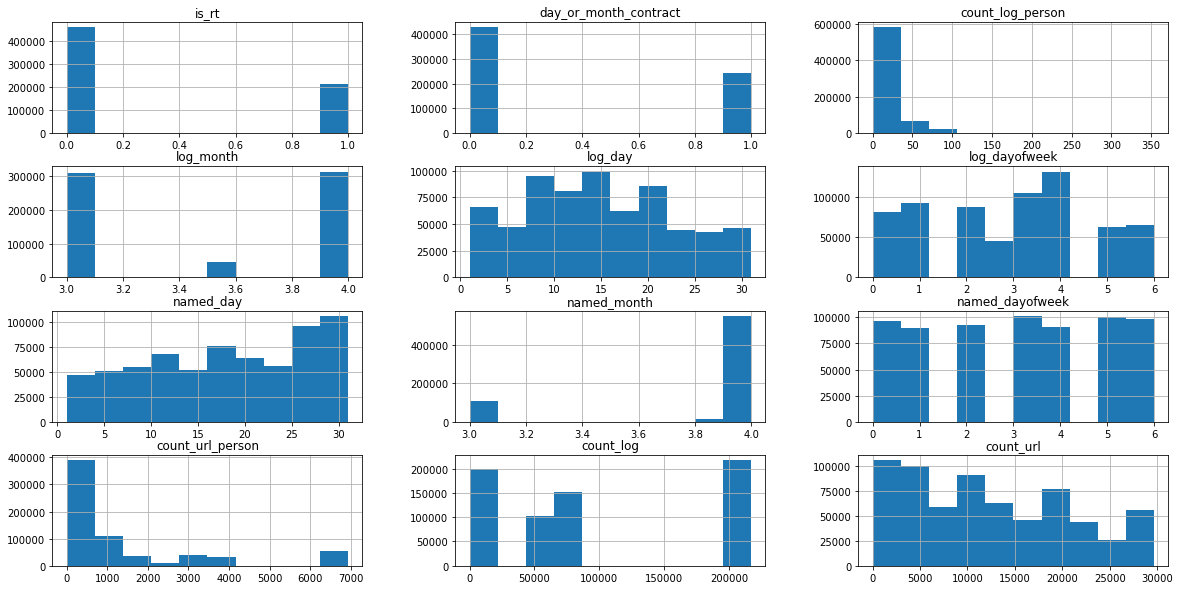

In [25]:
col = ['is_rt', 'day_or_month_contract', 'count_log_person', 'log_month', 'log_day', 'log_dayofweek', 'named_day', 'named_month', 'named_dayofweek', 'count_url_person', 'count_log', 'count_url']

_ = dftrain[col].hist(figsize=(20,10))

In [26]:
dftrain = dftrain.drop(dftrain[((dftrain.blocked != 3) & (dftrain.count_log_person > 100))].index, axis=0)
dftrain = dftrain.drop(dftrain[((dftrain.blocked != 3) & (dftrain.count_url_person > 2000))].index, axis=0)
dftrain = dftrain.drop(dftrain[((dftrain.blocked != 3) & (dftrain.count_url < 50))].index, axis=0)
dftrain = dftrain.drop(dftrain[((dftrain.blocked != 3) & (dftrain.count_log < 50))].index, axis=0)

In [27]:
dftrain.isna().sum()

contract_id              0
blocked                  0
day_or_month_contract    0
event_type               0
count_log_person         0
log_month                0
log_day                  0
log_dayofweek            0
url                      0
named_day                0
named_month              0
named_dayofweek          0
is_rt                    0
count_url_person         0
count_log                0
count_url                0
dtype: int64

##### Разделим данные на обучающую и тестовую выборки

In [28]:
df_test = dftrain[dftrain.blocked == 3]
X_train = dftrain[dftrain.blocked != 3]

## Подготовим датасет к обучению

In [29]:
X_train.shape

(442205, 16)

In [30]:
# X_train = X_train.drop_duplicates()

In [31]:
X_train.dtypes

contract_id                int64
blocked                    int64
day_or_month_contract    float64
event_type                object
count_log_person         float64
log_month                float64
log_day                  float64
log_dayofweek            float64
url                       object
named_day                float64
named_month              float64
named_dayofweek          float64
is_rt                    float64
count_url_person         float64
count_log                float64
count_url                float64
dtype: object

In [32]:
X = X_train.drop(["blocked"], axis = 1)
y = X_train[["blocked"]]
X = X.drop(columns='contract_id')
X

,day_or_month_contract,event_type,count_log_person,log_month,log_day,log_dayofweek,url,named_day,named_month,named_dayofweek,is_rt,count_url_person,count_log,count_url
0,0.0,Отключение услуги Автоплатёж,9.0,3.0,17.0,2.0,start.sampo.ru,29.0,4.0,3.0,0.0,83.0,829.0,5931.0
1,0.0,Отключение услуги Автоплатёж,9.0,3.0,17.0,2.0,profile.sampo.ru,29.0,4.0,3.0,0.0,83.0,829.0,11199.0
2,0.0,Отключение услуги Автоплатёж,9.0,3.0,17.0,2.0,vhod.sampo.ru,29.0,4.0,3.0,0.0,83.0,829.0,15204.0
3,0.0,Отключение услуги Автоплатёж,9.0,3.0,17.0,2.0,kino.sampo.ru,29.0,4.0,3.0,0.0,83.0,829.0,6787.0
4,0.0,Отключение услуги Автоплатёж,9.0,3.0,17.0,2.0,lk.sampo.ru,29.0,4.0,3.0,0.0,83.0,829.0,15142.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619172,1.0,Обращение в службу заботы о клиентах,9.0,4.0,28.0,2.0,fnc.rt.ru,5.0,4.0,0.0,1.0,1.0,85544.0,19637.0
619173,1.0,Обращение в службу заботы о клиентах,9.0,4.0,29.0,3.0,fnc.rt.ru,5.0,4.0,0.0,1.0,1.0,85544.0,19637.0
619174,1.0,Включение интернета на 20 минут с IVR,9.0,4.0,25.0,6.0,fnc.rt.ru,5.0,4.0,0.0,1.0,1.0,2267.0,19637.0
619175,1.0,Информер ВК. Показ,9.0,4.0,26.0,0.0,fnc.rt.ru,5.0,4.0,0.0,1.0,1.0,217233.0,19637.0


## Обучение модели

In [33]:
scorer = make_scorer(recall_score, average='macro', zero_division = 0)

cat_features = list(['event_type', 'url'])
class_weights_sqrt = {i : ((y == 0).values.sum() / (y == i).values.sum()) ** 0.5 for i in ([0, 1])}
rcv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)

param_grid={
            'loss_function':['Logloss'],
            'learning_rate':[0.3],
            'class_weights':[class_weights_sqrt],
            'cat_features':[cat_features],
            'iterations':[500],
            'depth':[1],
            'random_state':[42],
            'verbose': [False],
            }

boost_CV = HalvingGridSearchCV(
            CatBoostClassifier(),
            param_grid=param_grid,
            scoring=scorer,
            cv=rcv,
            verbose=False,
            n_jobs=-1
        )

boost_CV.fit(X, y)
model = boost_CV.best_estimator_
print(boost_CV.best_params_)
print(boost_CV.best_score_)

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'cat_features': ['event_type', 'url'], 'class_weights': {0: 1.0, 1: 4.322519564320161}, 'depth': 1, 'iterations': 500, 'learning_rate': 0.3, 'loss_function': 'Logloss', 'random_state': 42, 'verbose': False}
0.824970911109843


## Predict

In [34]:
X_test = df_test.drop(columns=['blocked'])
X_test.index = X_test.contract_id
X_test = X_test.drop(columns='contract_id')
X_test

,day_or_month_contract,event_type,count_log_person,log_month,log_day,log_dayofweek,url,named_day,named_month,named_dayofweek,is_rt,count_url_person,count_log,count_url
contract_id,,,,,,,,,,,,,,
3453,0.0,Информер ВК. Показ,1.0,3.000000,3.000000,2.000000,Nothing,17.510673,3.836795,3.037692,0.0,0.0,217233.0,0.0
3454,1.0,Внутреннее сообщение,1.0,4.000000,28.000000,2.000000,Nothing,17.510673,3.836795,3.037692,0.0,0.0,5218.0,0.0
3455,1.0,Nothing,0.0,3.502026,14.457513,2.897841,swap.sampo.ru,25.000000,4.000000,6.000000,0.0,24.0,0.0,12410.0
3455,1.0,Nothing,0.0,3.502026,14.457513,2.897841,kino.sampo.ru,8.000000,4.000000,3.000000,0.0,24.0,0.0,6787.0
3455,1.0,Nothing,0.0,3.502026,14.457513,2.897841,go.sampo.ru,8.000000,4.000000,3.000000,0.0,24.0,0.0,1038.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4261,0.0,Информер ВК. Показ,18.0,3.000000,29.000000,0.000000,Nothing,17.510673,3.836795,3.037692,0.0,0.0,217233.0,0.0
4261,0.0,Информер ВК. Показ,18.0,3.000000,29.000000,0.000000,Nothing,17.510673,3.836795,3.037692,0.0,0.0,217233.0,0.0
4261,0.0,Включение интернета на 20 минут,18.0,3.000000,31.000000,2.000000,Nothing,17.510673,3.836795,3.037692,0.0,0.0,56076.0,0.0


In [35]:
X_test.isna().sum()

day_or_month_contract    0
event_type               0
count_log_person         0
log_month                0
log_day                  0
log_dayofweek            0
url                      0
named_day                0
named_month              0
named_dayofweek          0
is_rt                    0
count_url_person         0
count_log                0
count_url                0
dtype: int64

In [36]:
pred_cat = model.predict(X_test)
X_test['pred_cat'] = pred_cat
ans = X_test.groupby(X_test.index).sum()
ans.loc[(ans.pred_cat > 0)] = 1
ans


,day_or_month_contract,count_log_person,log_month,log_day,log_dayofweek,named_day,named_month,named_dayofweek,is_rt,count_url_person,count_log,count_url,pred_cat
contract_id,,,,,,,,,,,,,
3453,0.0,1.0,3.000000,3.000000,2.000000,17.510673,3.836795,3.037692,0.0,0.0,217233.0,0.0,0
3454,1.0,1.0,4.000000,28.000000,2.000000,17.510673,3.836795,3.037692,0.0,0.0,5218.0,0.0,0
3455,24.0,0.0,84.048628,346.980311,69.548178,377.000000,96.000000,82.000000,5.0,576.0,0.0,200359.0,0
3456,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1
3457,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4258,3.0,9.0,10.000000,34.000000,6.000000,52.532018,11.510384,9.113077,0.0,0.0,138543.0,0.0,0
4259,484.0,0.0,1694.980663,6997.436274,1402.554914,8394.000000,1874.000000,1210.000000,8.0,234256.0,0.0,4534046.0,0
4260,0.0,81.0,99.000000,558.000000,81.000000,756.000000,108.000000,54.000000,0.0,243.0,5865291.0,431061.0,0


In [37]:
pred_cat = ans.pred_cat
pred_cat.sum()

158

In [65]:
answer = pd.DataFrame({'blocked': pred_cat}, index=df_sample_solution.contract_id)
answer

,blocked
contract_id,
3453,0
3454,0
3455,0
3456,1
3457,0
...,...
4258,0
4259,0
4260,0


In [66]:
answer.sum()

blocked    117
dtype: int64

In [67]:
answer.to_csv("sample_solution_test333.csv")
